In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Kaggle/datasets

/content/drive/MyDrive/Kaggle/datasets


In [3]:
# !pip install -q --upgrade "jax[cuda11_cudnn805]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
# !pip install -q --upgrade jaxlib
!pip install -q flax

     |████████████████████████████████| 180 kB 24.2 MB/s 
     |████████████████████████████████| 217 kB 71.1 MB/s 
     |████████████████████████████████| 145 kB 72.0 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 


In [4]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn

import tensorflow as tf
AUTOTUNE= tf.data.AUTOTUNE

from PIL import Image
import matplotlib.pyplot as plt

import os
from glob import glob
from functools import partial

from tqdm import tqdm
import pandas as pd

In [6]:
IMAGE_SIZE = 256
MAX_TRAIN_IMAGES = 1024
BATCH_SIZE = 64
TRAIN_VAL_IMAGE_DIR = "train/"
TEST_IMAGE_DIR = "eval/low"

In [7]:
train_val_image_files = glob(os.path.join(TRAIN_VAL_IMAGE_DIR, "*.jpg"))
train_image_files = train_val_image_files[:MAX_TRAIN_IMAGES]
val_image_files = train_val_image_files[MAX_TRAIN_IMAGES:]

print("Number of Training Images:", len(train_image_files))
print("Number of Validation Images:", len(val_image_files))

Number of Training Images: 1024
Number of Validation Images: 183
Number of Test Images from LOL Dataset: 15


In [8]:
def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image


def get_dataset(images):
    dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [29]:
train_dataset = get_dataset(train_image_files)
eval_dataset = get_dataset(val_image_files)

In [14]:
imgs = next(iter(train_dataset))

In [45]:
def get_test_dataset(path):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels=None, image_size=(256, 256), batch_size=128
    )
    lst = []
    for batch in dataset:
        lst.extend(batch / 255)
    return jnp.array(lst)

test_imgs = get_test_dataset('eval/low')

Found 15 files belonging to 1 classes.


(64, 256, 256, 3)


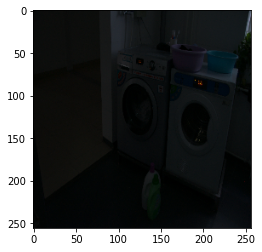

In [49]:
plt.imshow(imgs[0])
print(imgs.shape)

## Model and its functions

In [50]:
def get_enhanced_image(org_img, output):
    for i in range(0, 3 * 8, 3):
        r = output[:, :, :, i : i + 3]
        org_img = org_img + r * (jnp.square(org_img) - org_img)
    return org_img

#### Loss Functions

In [51]:
def color_constancy_loss(x):
    mean_rgb = jnp.mean(x, axis=(1, 2), keepdims=True)
    mean_red = mean_rgb[:, :, :, 0]
    mean_green = mean_rgb[:, :, :, 1]
    mean_blue = mean_rgb[:, :, :, 2]
    diff_red_green = jnp.square(mean_red - mean_green)
    diff_red_blue = jnp.square(mean_red - mean_blue)
    diff_green_blue = jnp.square(mean_blue - mean_green)
    return jnp.sqrt(
        jnp.square(diff_red_green)
        + jnp.square(diff_red_blue)
        + jnp.square(diff_green_blue)
    )

In [52]:
def exposure_loss(x, mean_val=0.6):
    x = jnp.mean(x, axis=3, keepdims=True)
    mean = nn.avg_pool(x, (16, 16), strides=(16, 16))
    return jnp.mean(jnp.square(mean - mean_val))

In [53]:
def illumination_smoothness_loss(x):
    batch_size = x.shape[0]
    height_x = x.shape[1]
    width_x = x.shape[2]

    count_height = (width_x - 1) * x.shape[3]
    count_width = width_x * (x.shape[3] - 1)

    heigth_total_variance = jnp.sum(jnp.square(x[:, 1:, :, :] - x[:, : height_x - 1, :, :]))
    width_total_variance = jnp.sum(jnp.square(x[:, :, 1:, :] - x[:, :, : width_x - 1, :]))

    return (2 * (heigth_total_variance / count_height + width_total_variance / count_width)/ batch_size)

In [54]:
class SpatialConsistencyLoss:
    def __init__(self):
        self.conv = partial(nn.Conv, features=1, kernel_size=(3, 3))
        self.left_conv = self.conv(kernel_init=self.init_lk)
        self.right_conv = self.conv(kernel_init=self.init_rk)
        self.up_conv = self.conv(kernel_init=self.init_uk)
        self.down_conv = self.conv(kernel_init=self.init_dk)

        self.left_params = self.init_params(self.left_conv, jnp.ones([1, 64, 64, 1]))
        self.right_params = self.init_params(self.right_conv, jnp.ones([1, 64, 64, 1]))
        self.up_params = self.init_params(self.up_conv, jnp.ones([1, 64, 64, 1]))
        self.down_params = self.init_params(self.right_conv, jnp.ones([1, 64, 64, 1]))

    def init_lk(self, *args):
        return jnp.array(
            [[[[0]], [[0]], [[0]]], [[[-1]], [[1]], [[0]]], [[[0]], [[0]], [[0]]]]
        )

    def init_rk(self, *args):
        return jnp.array(
            [[[[0]], [[0]], [[0]]], [[[0]], [[1]], [[-1]]], [[[0]], [[0]], [[0]]]]
        )

    def init_uk(self, *args):
        return jnp.array(
            [[[[0]], [[-1]], [[0]]], [[[0]], [[1]], [[0]]], [[[0]], [[0]], [[0]]]]
        )

    def init_dk(self, *args):
        return jnp.array(
            [[[[0]], [[0]], [[0]]], [[[0]], [[1]], [[0]]], [[[0]], [[-1]], [[0]]]]
        )

    def init_params(self, conv, x):
        return conv.init(jax.random.PRNGKey(0), x)

    def __call__(self, org, enhance):
        org_mean = jnp.mean(org, axis=3, keepdims=True)
        enhance_mean = jnp.mean(enhance, axis=3, keepdims=True)

        org_pool = nn.avg_pool(org_mean, window_shape=(4, 4), strides=(4, 4))
        enhance_pool = nn.avg_pool(enhance_mean, window_shape=(4, 4), strides=(4, 4))

        # left kernel
        d_org_left = self.left_conv.apply(self.left_params, org_pool)
        d_enhance_left = self.left_conv.apply(self.left_params, enhance_pool)

        # right kernel
        d_org_right = self.right_conv.apply(self.right_params, org_pool)
        d_enhance_right = self.right_conv.apply(self.right_params, enhance_pool)

        # up kernel
        d_org_up = self.up_conv.apply(self.up_params, org_pool)
        d_enhance_up = self.up_conv.apply(self.up_params, enhance_pool)

        # down kernel
        d_org_down = self.down_conv.apply(self.down_params, org_pool)
        d_enhance_down = self.down_conv.apply(self.down_params, enhance_pool)

        d_left = jnp.square(d_org_left - d_enhance_left)
        d_right = jnp.square(d_org_right - d_enhance_right)
        d_up = jnp.square(d_org_up - d_enhance_up)
        d_down = jnp.square(d_org_down - d_enhance_down)
        return d_left + d_right + d_up + d_down

#### Model

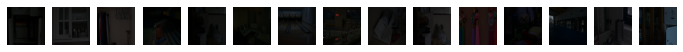

In [73]:
def plot_results(images, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1)
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()
plot_results(test_imgs)

In [21]:
class dce_net(nn.Module):
    loss_spa: None

    @nn.compact
    def __call__(self, x):

        x1 = nn.Conv(32, kernel_size=(3, 3))(x)
        x1 = nn.relu(x1)
        x2 = nn.Conv(32, kernel_size=(3, 3))(x1)
        x2 = nn.relu(x2)
        x3 = nn.Conv(32, kernel_size=(3, 3))(x2)
        x3 = nn.relu(x3)
        x4 = nn.Conv(32, kernel_size=(3, 3))(x3)
        x4 = nn.relu(x4)

        new_x1 = jnp.concatenate([x4, x3], axis=-1)
        x5 = nn.Conv(32, kernel_size=(3, 3))(new_x1)
        x5 = nn.relu(x5)

        new_x2 = jnp.concatenate([x5, x2], axis=-1)
        x6 = nn.Conv(32, kernel_size=(3, 3))(new_x2)
        x6 = nn.relu(x6)

        new_x3 = jnp.concatenate([x6, x1], axis=-1)
        x7 = nn.Conv(24, kernel_size=(3, 3))(new_x3)
        output = nn.tanh(x7)
        return output

    def loss_fn(self, params, org):
        output = self.apply(params, org)
        enhanced_y = get_enhanced_image(org, output)

        loss_ls = 200 * illumination_smoothness_loss(output)
        loss_spa = jnp.mean(self.loss_spa(org, enhanced_y))
        loss_color = 5 * jnp.mean(color_constancy_loss(enhanced_y))
        loss_exp = 10 * jnp.mean(exposure_loss(enhanced_y))

        total_loss = loss_ls + loss_spa + loss_color + loss_exp

        return total_loss

    def predict(self, params, x):
        output = self.apply(params, x)
        return get_enhanced_image(x, output)

#### Fit Function

In [22]:
def fit(model, params, train_ds, batch_size=32, learning_rate=0.01, epochs=10, rng=jax.random.PRNGKey(0)):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    loss_grad_fn = jax.jit(jax.value_and_grad(model.loss_fn))
    losses = []
    batches_per_epoch = 1024//64
    for i in range(epochs):
        for j in tqdm(range(batches_per_epoch)):
            X = next(iter(train_ds))
            X = jnp.array(X)
            loss_val, grads = loss_grad_fn(params, X)
            updates, opt_state = opt.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
        
        print(f'Loss after {i} epoch : ', loss_val)
    return params, loss_val

## Train

In [23]:
model = dce_net(SpatialConsistencyLoss())

In [24]:
model.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 256, 256, 3)))

                        dce_net Summary                         
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs               ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[1,256,256,3]  │                            │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_0  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,3,32]  │
│         │                       │                            │
│         │                       │ 896 (3.6 KB)               │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_1  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,32,32] │
│         │                       │                            │
│         │                       │ 9,248 (37.0 KB)            │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_2  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,32,32] │
│         │                       │                            │
│         │                       │ 9,248 (37.0 KB)            │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_3  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,32,32] │
│         │                       │                            │
│         │                       │ 9,248 (37.0 KB)            │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_4  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,64,32] │
│         │                       │                            │
│         │                       │ 18,464 (73.9 KB)           │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_5  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,64,32] │
│         │                       │                            │
│         │                       │ 18,464 (73.9 KB)           │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_6  │ float32[1,256,256,24] │ bias: float32[24]          │
│         │                       │ kernel: float32[3,3,64,24] │
│         │                       │                            │
│         │                       │ 13,848 (55.4 KB)           │
├─────────┼───────────────────────┼────────────────────────────┤
│ dce_net │ float32[1,256,256,24] │                            │
├─────────┼───────────────────────┼────────────────────────────┤
│         │                 Total │ 79,416 (317.7 KB)          │
└─────────┴───────────────────────┴────────────────────────────┘
                                                                
              Total Parameters: 79,416 (317.7 KB)               

'\n\n'

In [25]:
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 256, 256, 3)))

In [26]:
params, losses = fit(model, params, train_dataset, batch_size=64, learning_rate=0.0001, epochs=60)

100%|██████████| 16/16 [00:39<00:00,  2.48s/it]


Loss after 0 epoch :  33.267784


100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


Loss after 1 epoch :  24.654116


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Loss after 2 epoch :  18.912804


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Loss after 3 epoch :  14.923998


 62%|██████▎   | 10/16 [00:16<00:09,  1.66s/it]


KeyboardInterrupt: ignored

In [ ]:
pd.to_pickle(params, "model_params.pkl")

## Test

In [ ]:
params = pd.read_pickle("model_params.pkl")

In [ ]:
test_preds = model.predict(params, test_imgs)

In [ ]:
plot_results(test_preds)